In [125]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

import ruptures as rpt

In [4]:
df = pd.read_csv('../../../rmftsa_ladata.csv')

Relatywnie mały zbiór danych, zawierający jedynie zmienne numeryczne

In [59]:
target = 'Total_Mortality'
X = df.loc[:, df.columns != target]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
X_train.head()

,Respiratory_Mortality,Cardiovascular_Mortality,Temperature,Relative_Humidity,Carbon_Monoxide,Sulfur_Dioxideglm.LAshumway,Nitrogen_Dioxide,Hydrocarbons,Ozone,Particulates
0,11.90,97.85,72.38,29.20,11.51,3.37,9.64,45.79,6.69,72.72
365,7.66,79.68,77.07,57.10,10.06,4.07,20.69,71.71,9.94,59.88
495,8.53,74.89,78.23,69.98,2.52,1.50,5.72,27.64,10.29,35.50
9,7.44,88.75,67.09,50.94,7.90,2.56,7.43,40.20,7.63,40.41
107,7.93,90.48,68.57,77.31,8.25,4.82,15.19,57.08,9.73,49.20


In [61]:
def ALE_plot(model, data, column, num_of_intervals):
    # funkcja zwracjąca współrzedne do wykresu ALE_plot wybranej zmiennej dla zadanej liczby przedziałów
    intervals_df = pd.qcut(data[column], num_of_intervals, duplicates='drop')
    
    data_left = data.copy()
    data_left.loc[:, column] = intervals_df.apply(lambda x: x.left)
    
    data_right = data.copy()
    data_right.loc[:, column] = intervals_df.apply(lambda x: x.right)
    
    left_preds = model.predict(data_left)
    right_preds = model.predict(data_right)
    
    intervals_df.index = range(len(intervals_df))
    intervals_df = pd.concat([intervals_df, pd.Series(right_preds - left_preds, name='proba_diff')], axis=1)
    intervals = [(i.right, intervals_df.loc[intervals_df[column] == i, 'proba_diff'].mean())
                 for i in sorted(intervals_df[column].unique())]
    cumsum = 0
    intervals_with_cs = [(0, 0, 0)]
    for i in intervals:
        cumsum += i[1]
        intervals_with_cs.append(i + (cumsum,))
    x, y = [i[0] for i in intervals_with_cs], [i[2] for i in intervals_with_cs]
    y = list(np.array(y) - np.array(y).mean())
    return x, y

Funkcja znajdująca breakpointy w oparciu o ALE plot dla wybranego modelu. Może je wyświetlić wraz z wykresem ALE plot.

In [62]:
def find_break_points_based_on_ALE_plot(X, model, show_plots=True):
    breakpoints_for_cols = {}

    for col in X.columns:
        x_ale, y_ale = ALE_plot(model, X, col, 200)
        breakpoints_coordinates = rpt.Pelt(model="rbf").fit(np.array(y_ale)).predict(pen=10)
        breakpoints = [x_ale[i] for i in breakpoints_coordinates[:-1]]

        if show_plots:    
            plt.plot(x_ale, y_ale)
            for breakpoint in breakpoints:
                plt.axvline(x=breakpoint, color='r', linestyle='--')
            plt.title(f'ALE plot with breakpoints for {col}')
            plt.show()

        breakpoints_for_cols[col] = breakpoints
    
    return breakpoints_for_cols

Klasa zmieniająca zmienne numeryczne w jakościowe na podstawie breakpointów. W połączeniu z powyższą funkcją tworzy podziały automatycznie.

In [63]:
def get_col_names(col, vals):
    col_names = [f'{col}_below_{vals[0]}']
    for val1, val2 in zip(vals[:-1], vals[1:]):
        col_names.append(f'{col}_between_{val1}_and_{val2}')
    col_names.append(f'{col}_above_{vals[-1]}')
    return col_names

class ApplyBreakpoints(TransformerMixin):
    
    def __init__(self, breakpoints):
        self.breakpoints = {bp: [-np.inf] + breakpoints[bp] + [np.inf] for bp in breakpoints}

    def fit(self, X, y=None, **kwargs):
        return self

    def transform(self, X, y=None, **kwargs):
        new_col_names_dict = {col: get_col_names(col, self.breakpoints[col][1:-1]) for col in X.columns}
        all_new_cols = [name for col in new_col_names_dict for name in new_col_names_dict[col]]
        X_trans = pd.DataFrame(columns=all_new_cols)
        for col in X.columns:
            for i, bp in enumerate(self.breakpoints[col][:-1]):
                X_trans[new_col_names_dict[col][i]] = X[col].apply(lambda x: 1 if bp < x <= self.breakpoints[col][i + 1] else 0)
                
        return X_trans

Random Forest - jak się okazuje lepszy z dwóch elastycznych modeli i w oparciu o niego powstaną breakpointy

In [141]:
forest = RandomForestRegressor(
    max_depth=7,
    max_features=6,
    min_samples_split=2,
    n_estimators=400,
    min_impurity_decrease=0.4,
    n_jobs=-1
)

forest.fit(X_train, y_train)
mse_train_forest = mean_squared_error(y_train, forest.predict(X_train))
mse_test_forest = mean_squared_error(y_test, forest.predict(X_test))
print(mse_train_forest, mse_test_forest)

11.138123806347553 21.160465388676975


Cat boost - gorszy z dwóch elastycznych modeli

In [127]:
cat_boost = CatBoostRegressor(
    learning_rate=0.2,
    max_depth=3,
    l2_leaf_reg=0.1,
    n_estimators=600,
    verbose=0,
)

cat_boost.fit(X_train, y_train)
mse_train_cat_boost = mean_squared_error(y_train, cat_boost.predict(X_train))
mse_test_cat_boost = mean_squared_error(y_test, cat_boost.predict(X_test))
print(mse_train_cat_boost, mse_test_cat_boost)

14.178418390098221 25.415720152408156


Regresja liniowa - jak się okazuje najlepszy (na zbiorze testowym) model

In [128]:
basic_lin_reg = LinearRegression()
basic_lin_reg.fit(X_train, y_train)
mse_train_lin_reg = mean_squared_error(y_train, basic_lin_reg.predict(X_train))
mse_test_lin_reg = mean_squared_error(y_test, basic_lin_reg.predict(X_test))
print(mse_train_lin_reg, mse_test_lin_reg)

18.360380580810006 19.616623102155845


ALE ploty z zaznaczonymi breakpointami dla wszystkich zmiennych. Widzimy, że zmienne są dość zróżnicowane jeśli chodzi o wpływ na model.

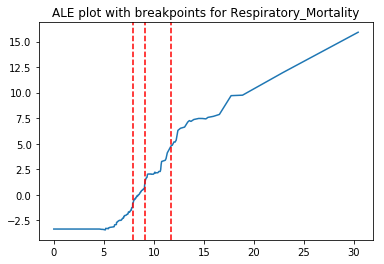

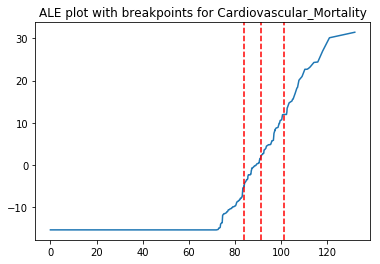

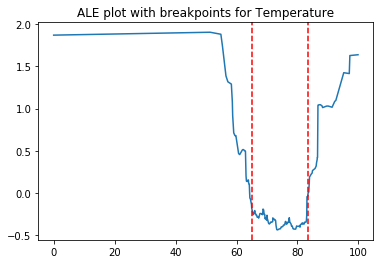

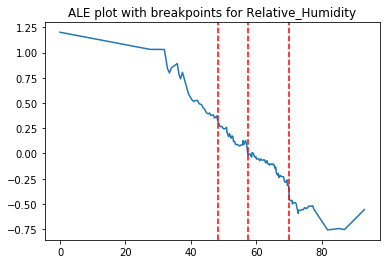

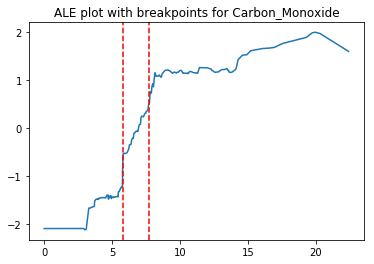

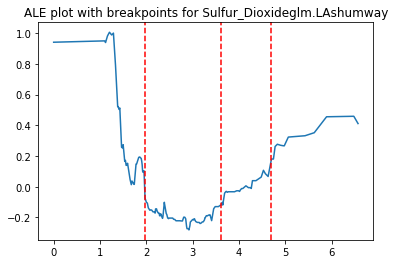

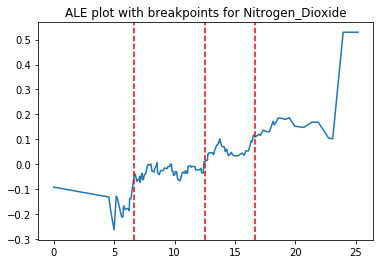

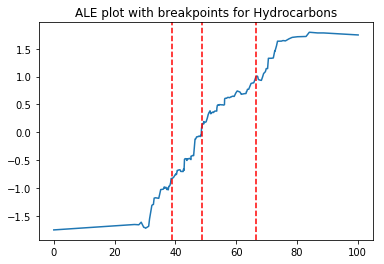

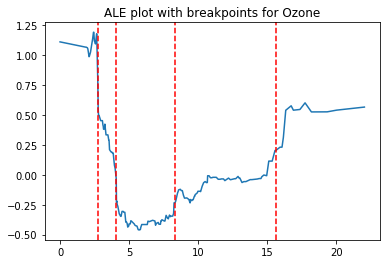

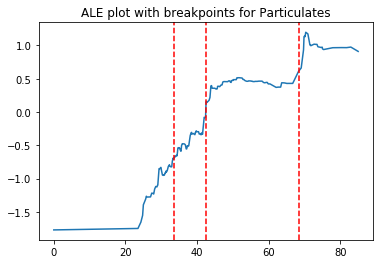

In [84]:
breakpoints = find_break_points_based_on_ALE_plot(X_train, forest)

Regresja liniowa oparta na breakpointach - najsłabszy model z wypróbowanych.

In [133]:
X_transformed_train = ApplyBreakpoints(breakpoints).fit_transform(X_train)
X_transformed_test = ApplyBreakpoints(breakpoints).fit_transform(X_test)

impr_lin_reg = LinearRegression()
impr_lin_reg.fit(X_transformed_train, y_train)

mse_train_impr_lin_reg = mean_squared_error(y_train, impr_lin_reg.predict(X_transformed_train))
mse_test_impr_lin_reg = mean_squared_error(y_test, impr_lin_reg.predict(X_transformed_test))
print(mse_train_impr_lin_reg, mse_test_impr_lin_reg)

31.157990294027087 36.39279192708332


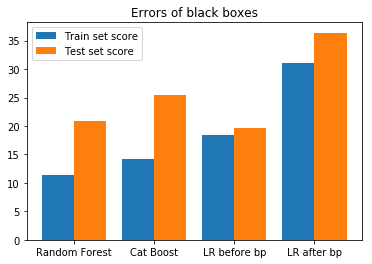

In [139]:
bar_width = 0.4

plt.figure()
plt.title("Errors of black boxes")
plt.bar(np.arange(4) - bar_width/2, 
        [mse_train_forest, mse_train_cat_boost, mse_train_lin_reg, mse_train_impr_lin_reg],
        width = bar_width,
        label="Train set score",
        align="center")
plt.bar(np.arange(4) + bar_width/2, 
        [mse_test_forest, mse_test_cat_boost, mse_test_lin_reg, mse_test_impr_lin_reg],
        width = bar_width,
        label="Test set score",
        align="center")
plt.legend()
plt.xticks(np.arange(4), ['Random Forest', 'Cat Boost', 'LR before bp', 'LR after bp'])
plt.show()

In [144]:
for col, weight in zip(X.columns, basic_lin_reg.coef_):
    print(f'Weight for {col} = {weight}')

Weight for Respiratory_Mortality = 1.3346813241339524
Weight for Cardiovascular_Mortality = 1.0644575004409433
Weight for Temperature = -0.009219482145575886
Weight for Relative_Humidity = -0.0037426582675964826
Weight for Carbon_Monoxide = 0.13797944298188247
Weight for Sulfur_Dioxideglm.LAshumway = -1.1078017792173844
Weight for Nitrogen_Dioxide = -0.28485299990896495
Weight for Hydrocarbons = 0.12719469088592442
Weight for Ozone = 0.46491376778601756
Weight for Particulates = 0.053682014817358126


In [145]:
for col, weight in zip(X_transformed_train.columns, impr_lin_reg.coef_):
    print(f'Weight for {col} = {weight}')

Weight for Respiratory_Mortality_below_7.8755 = -150616544111535.22
Weight for Respiratory_Mortality_between_7.8755_and_9.13 = -150616544111532.44
Weight for Respiratory_Mortality_between_9.13_and_11.759 = -150616544111528.88
Weight for Respiratory_Mortality_above_11.759 = -150616544111521.3
Weight for Cardiovascular_Mortality_below_83.9162 = 73480254850262.03
Weight for Cardiovascular_Mortality_between_83.9162_and_91.465 = 73480254850270.81
Weight for Cardiovascular_Mortality_between_91.465_and_101.262 = 73480254850277.31
Weight for Cardiovascular_Mortality_above_101.262 = 73480254850290.02
Weight for Temperature_below_64.921 = -28524208257739.812
Weight for Temperature_between_64.921_and_83.553 = -28524208257741.344
Weight for Temperature_above_83.553 = -28524208257740.61
Weight for Relative_Humidity_below_48.301 = 27620153497038.707
Weight for Relative_Humidity_between_48.301_and_57.55 = 27620153497039.957
Weight for Relative_Humidity_between_57.55_and_69.862 = 27620153497039.145
We

Jak widzimy najskuteczniejszym modelem okazała się zwykła regresja liniowa dla zwykłych zmiennych. Z kolei regresja liniowa po zastosowaniu metody SAFE okazała się zdecydowanie najgorszym modelem. Sugeruje to, że zależność ostatecznej wartości przewidywanej zmiennej od parametrów jest z grubsza liniowa i nie ma zbyt wielu przedziałów, na których zależność ta jest stała. Tę hipotezę potwierdzają również ALE ploty, które można zobaczyć powyżej - tam również w większości wypadków nie widać "wypłaszczeń" i faktycznie dla wielu zmiennych (zwłaszcza tych, którym regresja przypisała duże wagi) widać linową zależność zmiany wartości y od wartości zmiennej.